# Community Detection in FriendFeed Network

This notebook focuses on preparing the graph for detecting communities within the FriendFeed social network. 

We'll use the preprocessed datasets to build a graph and analyze community structures.

## 1. Import Libraries and Load Data

In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community
import random
import matplotlib.pyplot as plt
import gc
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import warnings
from collections import Counter
import time
from community import community_louvain

%matplotlib inline
sns.set(style='whitegrid')

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
start_time = time.time()

In [2]:
# Load preprocessed data
users = pd.read_parquet('processed_data/users_cleaned.parquet')
subs = pd.read_parquet('processed_data/subs_cleaned.parquet')
following = pd.read_parquet('processed_data/following_cleaned.parquet')
comments = pd.read_parquet('processed_data/comments_cleaned.parquet')
likes = pd.read_parquet('processed_data/likes_cleaned.parquet')
entries = pd.read_parquet('processed_data/entries_cleaned.parquet')

In [3]:
# Get the unique user IDs from both dataframes
user_ids_in_likes = set(likes['userID'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_likes - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'likes' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'likes' but not in 'users': 0


In [4]:
# Get the unique user IDs from both dataframes
user_ids_in_entries = set(entries['PostedBy'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_entries - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'entries' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'entries' but not in 'users': 0


In [5]:
# sizes of each dataframe
print('users:', users.shape)
print('subs:', subs.shape)
print('following:', following.shape)
print('comments:', comments.shape)
print('likes:', likes.shape)
print('entries:', entries.shape)

users: (645414, 4)
subs: (24761879, 2)
following: (18477145, 3)
comments: (2835155, 6)
likes: (427214, 3)
entries: (10954103, 5)


In [6]:
# length of unique users
print('df: users')
print(users.columns)
print('unique users:', len(users['ID'].unique()))
print('----------------------------\n')

print('df: subs')
print(subs.columns)
print('unique subs:', len(subs['FollowerID'].unique()))
print('unique subs:', len(subs['FollowedID'].unique()))
print('----------------------------\n')

print('df: following')
print(following.columns)
print('unique following:', len(following['FollowerID'].unique()))
print('unique following:', len(following['FollowedID'].unique()))
print('----------------------------\n')

print('df: comments')
print(comments.columns)
print('unique comments:', len(comments['PostedBy'].unique()))
print('----------------------------\n')

print('df: likes')
print(likes.columns)
print('unique likes:', len(likes['userID'].unique()))
print('----------------------------\n')

print('df: entries')
print(entries.columns)
print('unique entries:', len(entries['PostedBy'].unique()))

df: users
Index(['ID', 'Type', 'Name', 'Description'], dtype='object')
unique users: 645414
----------------------------

df: subs
Index(['FollowerID', 'FollowedID'], dtype='object')
unique subs: 525824
unique subs: 527108
----------------------------

df: following
Index(['FollowerID', 'FollowedID', 'Timestamp'], dtype='object')
unique following: 196436
unique following: 443552
----------------------------

df: comments
Index(['PostID', 'EntryID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique comments: 40919
----------------------------

df: likes
Index(['userID', 'PostID', 'Timestamp'], dtype='object')
unique likes: 13308
----------------------------

df: entries
Index(['PostID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique entries: 209716


## 2. Build the Network Graph

We'll create a directed graph where nodes represent users, and edges represent different types of interactions such as follows, likes, and comments.

In [7]:
%%time
# Initialize directed graph
G = nx.DiGraph()

# Add nodes for users
G.add_nodes_from(users['ID'])

# Display basic graph information
print(f"Graph has {G.number_of_nodes()}")

Graph has 645414
CPU times: user 683 ms, sys: 88.7 ms, total: 772 ms
Wall time: 769 ms


In [8]:
# Get the list of node names
node_names = list(G.nodes())
# Create a DataFrame from the node names
df = pd.DataFrame(node_names, columns=['NodeName'])

# Count duplicates
duplicate_counts = df['NodeName'].value_counts()

# Identify and display duplicates
duplicates = duplicate_counts[duplicate_counts > 1]

if not duplicates.empty:
    print("Duplicate node names found:")
    print(duplicates)
else:
    print("All node names are unique.")

All node names are unique.


In [9]:
# Define number of workers (cores)
num_workers = 12  # Adjust based on the number of available CPU cores

In [10]:
# Split DataFrame into smaller chunks for parallel processing
def split_dataframe(df, num_chunks):
    return np.array_split(df, num_chunks)

# Function to generate edges for a chunk of the DataFrame
def generate_edges_following(df_chunk):
    return [(row['FollowerID'], row['FollowedID']) for _, row in df_chunk.iterrows()]

# Function to generate edges for a chunk of the 'subs' DataFrame
def generate_edges_subs(df_chunk):
    return [(row['FollowerID'], row['FollowedID']) for _, row in df_chunk.iterrows()]

# Function to generate edges for a chunk of the 'likes' DataFrame
def generate_edges_likes(df_chunk, post_owner_mapping):
    edges = []
    for _, row in df_chunk.iterrows():
        user_id = row['userID']  # User who liked the post
        post_id = row['PostID']  # Post that was liked

        # Find the owner of the post
        if post_id in post_owner_mapping:
            post_owner = post_owner_mapping[post_id]
            # Add an edge from the user who liked the post to the owner of the post
            edges.append((user_id, post_owner))
    return edges

# Function to generate edges for a chunk of the 'comments' DataFrame
def generate_edges_comments(df_chunk, post_author_mapping):
    edges = []
    for _, row in df_chunk.iterrows():
        commenter = row['PostedBy']  # The user who made the comment
        entry_id = row['EntryID']    # The post (EntryID) on which the comment was made
        
        # Find the author of the post (EntryID)
        if entry_id in post_author_mapping:
            post_author = post_author_mapping[entry_id]
            # Add an edge from the commenter to the author of the post they commented on
            edges.append((commenter, post_author))
    return edges

###  Adding edges based on following

In [11]:
%%time
# Split the 'following' DataFrame into chunks
df_chunks = split_dataframe(following, num_workers)

# Parallelize edge creation
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_chunks = list(executor.map(generate_edges_following, df_chunks))

# Combine the edges from all workers
edges = [edge for chunk in edges_chunks for edge in chunk]

# Add edges to the graph
G.add_edges_from(edges, relationship='following')

# Display basic graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 18477145 edges
CPU times: user 55.6 s, sys: 6.7 s, total: 1min 2s
Wall time: 2min 45s


###  Adding edges based on subs

In [12]:
%%time
# Split the 'subs' DataFrame into chunks
df_chunks = split_dataframe(subs, num_workers)

# Parallelize edge creation for the 'subs' edges
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_chunks = list(executor.map(generate_edges_subs, df_chunks))

# Combine the edges from all workers
edges_subs = [edge for chunk in edges_chunks for edge in chunk]

# Add edges to the graph
G.add_edges_from(edges_subs, relationship='subs')

# Display basic graph information after adding edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39380139 edges
CPU times: user 1min 9s, sys: 10.2 s, total: 1min 19s
Wall time: 3min 36s


###  Adding edges based on likes

In [13]:
%%time
# Step 1: Create a mapping of PostID to the user who owns the post (from the 'entries' DataFrame)
post_owner_mapping = dict(zip(entries['PostID'], entries['PostedBy']))

# Split the 'likes' DataFrame into chunks
df_chunks = split_dataframe(likes, num_workers)

# Parallelize edge creation for the 'likes' edges
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_likes_chunks = list(executor.map(generate_edges_likes, df_chunks, [post_owner_mapping] * num_workers))

# Combine the edges from all workers
edges_likes = [edge for chunk in edges_likes_chunks for edge in chunk]

# Add the edges to the graph
G.add_edges_from(edges_likes, relationship='like')

# Display basic graph information after adding edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39431538 edges
CPU times: user 1min 13s, sys: 20.1 s, total: 1min 33s
Wall time: 1min 50s


###  Adding edges based on comment

In [14]:
%%time
# Step 1: Create a mapping of EntryID (PostID in comments) to the user who owns the post (from the 'entries' DataFrame)
post_author_mapping = dict(zip(entries['PostID'], entries['PostedBy']))

# Split the 'comments' DataFrame into chunks
df_chunks = split_dataframe(comments, num_workers)

# Parallelize edge creation for the 'comments' edges
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_comments_chunks = list(executor.map(generate_edges_comments, df_chunks, [post_author_mapping] * num_workers))

# Combine the edges from all workers
edges_comments = [edge for chunk in edges_comments_chunks for edge in chunk]

# Add the edges to the graph
G.add_edges_from(edges_comments, relationship='comment')

# Display updated graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39562155 edges
CPU times: user 1min 32s, sys: 24.2 s, total: 1min 57s
Wall time: 2min 25s


In [15]:
# Get the degree of each node (the number of edges connected to each node)
degree_counts = dict(G.degree())

# Prepare a list of degree values
degree_values = list(degree_counts.values())

# Count the frequency of each degree value
degree_distribution = Counter(degree_values)

# Display the number of nodes for each degree (0 edges, 1 edge, 2 edges, etc.)
# for degree, count in sorted(degree_distribution.items()):
    # print(f"Nodes with {degree} edges: {count}")

# Calculate min, max, average, and median of the degree values
min_degree = np.min(degree_values)
max_degree = np.max(degree_values)
average_degree = np.mean(degree_values)
median_degree = np.median(degree_values)

# Count the number of nodes with min and max edges
min_degree_count = degree_distribution[min_degree]
max_degree_count = degree_distribution[max_degree]

# Print statistics
print(f"\nMinimum degree: {min_degree} (Nodes: {min_degree_count})")
print(f"Maximum degree: {max_degree} (Nodes: {max_degree_count})")
print(f"Average degree: {average_degree:.2f}")
print(f"Median degree: {median_degree}")


Minimum degree: 0 (Nodes: 1998)
Maximum degree: 178290 (Nodes: 1)
Average degree: 122.59
Median degree: 9.0


### Plot samples from the network

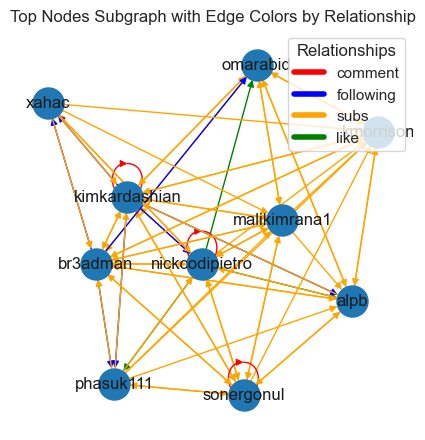

In [16]:
# Step 1: Specify the number of nodes to sample based on the most connections (highest degree)
num_nodes_to_sample = 10  # Set your desired number of nodes

# Get the degrees of all nodes (degree is the number of edges connected to a node)
node_degrees = dict(G.degree())

# Sort nodes by degree in descending order and select the top ones
sampled_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:num_nodes_to_sample]

# Step 2: Create a subgraph from the sampled nodes
G_sampled = G.subgraph(sampled_nodes).copy()

# Step 3: Prepare edge colors based on relationships
edge_colors = []
for u, v, data in G_sampled.edges(data=True):
    relationship = data['relationship']
    if relationship == 'following':
        edge_colors.append('blue')
    elif relationship == 'subs':
        edge_colors.append('orange')
    elif relationship == 'like':
        edge_colors.append('green')
    elif relationship == 'comment':
        edge_colors.append('red')
    else:
        edge_colors.append('gray')

# Step 4: Plot the sampled subgraph with colored edges
plt.figure(figsize=(4, 4))  # Set the plot size
nx.draw(G_sampled, node_size=500, edge_color=edge_colors, with_labels=True)

# Step 5: Create a legend for the edges
colors = {'following': 'blue', 'subs': 'orange', 'like': 'green', 'comment': 'red', 'other': 'gray'}

# Create legend entries
unique_relationships = set(data['relationship'] for _, _, data in G_sampled.edges(data=True))
for relationship in unique_relationships:
    plt.plot([], [], color=colors.get(relationship, 'gray'), label=relationship, linewidth=4)

plt.title('Top Nodes Subgraph with Edge Colors by Relationship')
plt.legend(title='Relationships', loc='upper right', bbox_to_anchor=(1, 1))
plt.show()


In [17]:
# Create a list of tuples (node, degree) and sort by degree in descending order
num_nodes_to_sample = 10
sorted_nodes_with_degrees = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes_to_sample]

# Display the sorted nodes with their degrees
for node, degree in sorted_nodes_with_degrees:
    print(f"Node: {node}, Degree: {degree}")

Node: br3adman, Degree: 178290
Node: malikimrana1, Degree: 166401
Node: sonergonul, Degree: 159406
Node: phasuk111, Degree: 159201
Node: omarabid, Degree: 143402
Node: xahac, Degree: 133903
Node: alpb, Degree: 109659
Node: nickcodipietro, Degree: 108931
Node: kimkardashian, Degree: 102530
Node: kmorrison, Degree: 102211


In [18]:
# Free up the memory
del users, subs, following, comments, likes, entries
gc.collect()

7978

### TEST, run louvain 

In [24]:
%%time
# Step 1: Apply the Louvain method
G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected)

CPU times: user 19min 29s, sys: 7.02 s, total: 19min 36s
Wall time: 19min 36s


In [144]:
# Add community information as node attribute
nx.set_node_attributes(G, partition, 'community')

In [25]:
# Step 2: Get the community information
# This creates a dictionary where keys are node ids and values are the community they belong to
print(f"Number of communities detected: {len(set(partition.values()))}")

Number of communities detected: 6968


### Save the network

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print graph information
print(f"Graph type: {type(G)}")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

In [ ]:
%%time
#### Extract edges along with their attributes
batch_size = 4000000  # Number of edges per file
edges = list(G.edges(data=True))

for i in range(0, len(edges), batch_size):
    chunk = edges[i:i + batch_size]
    # Create a subgraph with these edges and their attributes
    subgraph = nx.Graph()
    subgraph.add_edges_from(chunk)  # This will keep the edge attributes
    nx.write_graphml(subgraph, f"graph/graph_batch_{i//batch_size}.graphml")
    print(f'* graph/graph_batch_{i//batch_size}.graphml is written!')

In [ ]:
end_time = time.time()
total_seconds = end_time - start_time
minutes, seconds = divmod(total_seconds, 60) 
print(f"Execution time: {int(minutes)} minutes and {seconds:.2f} seconds")

In [99]:
%%time
# Step 3: Print the sizes of each community
community_sizes = {k: list(partition.values()).count(k) for k in set(partition.values())}
i = 0
for community, size in community_sizes.items():
    print(f"Community {community}: {size} nodes")
    i += 1
    if i == 7:
        break

Community 0: 94659 nodes
Community 1: 192242 nodes
Community 2: 1274 nodes
Community 3: 69397 nodes
Community 4: 13866 nodes
Community 5: 17776 nodes
Community 6: 82490 nodes
CPU times: user 59.5 s, sys: 10.9 ms, total: 59.5 s
Wall time: 59.5 s


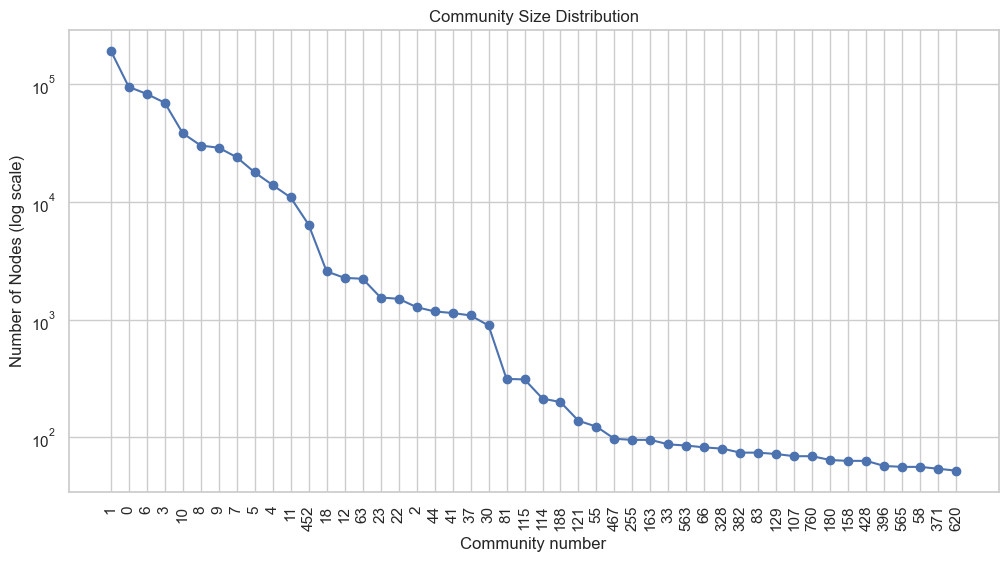

In [143]:
# Calculate size of each community
community_sizes = pd.Series(list(partition.values())).value_counts()

# Filter out communities with more than 100 users
community_sizes = community_sizes[community_sizes > 50]

# Plot the distribution as a line plot
plt.figure(figsize=(12, 6))
plt.plot(community_sizes.values, marker='o', linestyle='-', color='b')
plt.title('Community Size Distribution')
plt.xlabel('Community number')
plt.ylabel('Number of Nodes (log scale)')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Customize x-axis to show every community (community ID as the label)
plt.xticks(ticks=range(len(community_sizes)), labels=community_sizes.index, rotation=90)

plt.show()


In [118]:
# Calculate community sizes
community_sizes = {k: list(partition.values()).count(k) for k in set(partition.values())}

# Sort the communities by size in descending order and take the top 10 largest
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:15]

# Print the top 10 largest communities
for community, size in sorted_communities:
    print(f"Community {community}: {size} nodes")


Community 1: 192242 nodes
Community 0: 94659 nodes
Community 6: 82490 nodes
Community 3: 69397 nodes
Community 10: 38252 nodes
Community 8: 30071 nodes
Community 9: 28795 nodes
Community 7: 23924 nodes
Community 5: 17776 nodes
Community 4: 13866 nodes
Community 11: 10881 nodes
Community 452: 6387 nodes
Community 18: 2561 nodes
Community 12: 2258 nodes
Community 63: 2220 nodes


### Approach 1: Plotting only the largest communities

In [112]:
# Filter communities: Only include those with 100 or more members

def plot_communities_more_or_less_than(member_size, less_or_more='more'):
    if less_or_more == 'less':
        filtered_communities = {comm: size for comm, size in community_sizes.items() if size <= member_size}
    else:
        filtered_communities = {comm: size for comm, size in community_sizes.items() if size >= member_size}

    filtered_community_ids = set(filtered_communities.keys())
    print(f'Number of communities with {member_size} memebers is: {len(filtered_communities)}')
    
    # Create a metagraph where each node represents a filtered community
    metagraph = nx.Graph()
    
    # Add nodes to the metagraph representing each filtered community
    for community_id in filtered_community_ids:
        metagraph.add_node(community_id, size=filtered_communities[community_id])
    
    # Add edges between filtered communities if nodes in different communities are connected
    for u, v in G_undirected.edges():
        comm_u = partition[u]
        comm_v = partition[v]
        if comm_u in filtered_community_ids and comm_v in filtered_community_ids and comm_u != comm_v:
            if metagraph.has_edge(comm_u, comm_v):
                metagraph[comm_u][comm_v]['weight'] += 0.02
            else:
                metagraph.add_edge(comm_u, comm_v, weight=1)
    
    # Plot the filtered metagraph
    plt.figure(figsize=(6, 6))
    pos = nx.nx_pydot.graphviz_layout(metagraph)  # Layout for better visualization
    sizes = [metagraph.nodes[comm]['size'] * 0.03 for comm in metagraph.nodes()]  # Scale the node size by community size
    nx.draw(metagraph, pos, node_size=sizes, with_labels=True, font_size=8, node_color='lightgreen')
    plt.title(f"Metagraph of Communities with {less_or_more} than {member_size} Members")
    plt.show()


Number of communities with 2 memebers is: 5182


<Figure size 600x600 with 0 Axes>

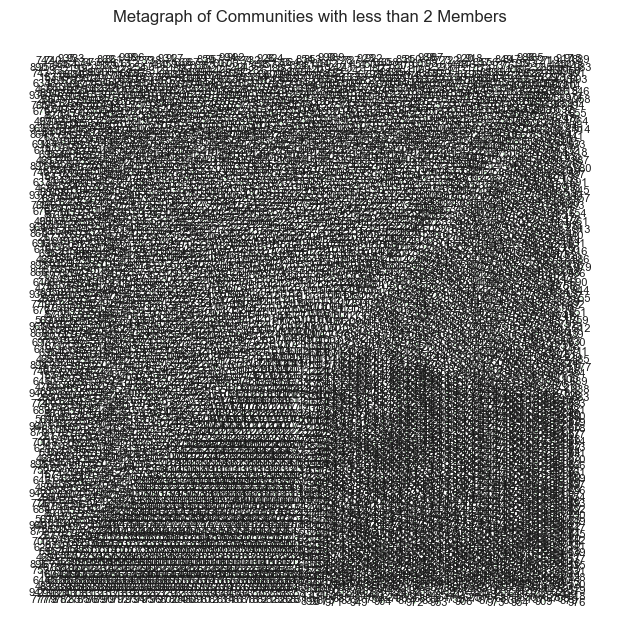

In [113]:
plot_communities_more_or_less_than(2, 'less')

Number of communities with 100 memebers is: 28


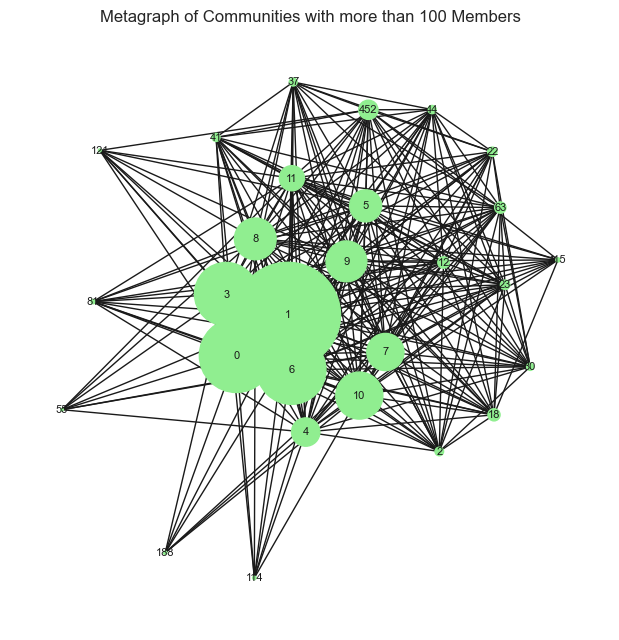

In [115]:
plot_communities_more_or_less_than(100, 'more')

Number of communities with 1000 memebers is: 21


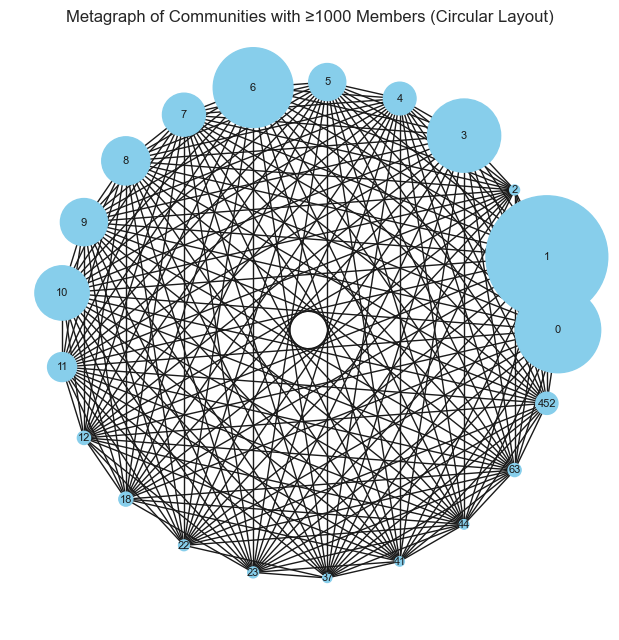

In [93]:
# Set the minimum community size for filtering
member_size = 1000

# Filter communities with size >= member_size
filtered_communities = {comm: size for comm, size in community_sizes.items() if size >= member_size}
filtered_community_ids = set(filtered_communities.keys())
print(f'Number of communities with {member_size} memebers is: {len(filtered_communities)}')

# Create a metagraph where each node represents a filtered community
metagraph = nx.Graph()

# Add nodes to the metagraph representing each filtered community
for community_id in filtered_community_ids:
    metagraph.add_node(community_id, size=filtered_communities[community_id])

# Add edges between filtered communities if nodes in different communities are connected
for u, v in G_undirected.edges():
    comm_u = partition[u]
    comm_v = partition[v]
    if comm_u in filtered_community_ids and comm_v in filtered_community_ids and comm_u != comm_v:
        if metagraph.has_edge(comm_u, comm_v):
            metagraph[comm_u][comm_v]['weight'] += 0.02
        else:
            metagraph.add_edge(comm_u, comm_v, weight=1)

# Adjust the layout to arrange nodes in a circular pattern
plt.figure(figsize=(6, 6))

# Use circular layout for better visualization of communities
pos = nx.circular_layout(metagraph)

# Scale the node size by community size
sizes = [metagraph.nodes[comm]['size'] * 0.04 for comm in metagraph.nodes()]

# Draw the metagraph with node sizes and circular layout
nx.draw(metagraph, pos, node_size=sizes, with_labels=True, font_size=8, cmap=plt.cm.rainbow, node_color='skyblue')

# Title the plot
plt.title(f"Metagraph of Communities with ≥{member_size} Members (Circular Layout)")

# Show the plot
plt.show()


## Approach 2: Plotting selected communities with all members

In [101]:
def plot_communities_with_members(min_member, max_member):
    # Filter communities based on size range (min_member to max_member)
    filtered_communities = {comm: size for comm, size in community_sizes.items() if min_member <= size <= max_member}
    filtered_community_ids = set(filtered_communities.keys())
    print(f'Number of communities with memebers between {min_member} and {max_member} is: {len(filtered_communities)}')
    
    # Filter out the nodes that belong to the selected communities
    nodes_to_plot = [node for node, comm in partition.items() if comm in filtered_community_ids]
    
    # Create a subgraph containing only those nodes
    subgraph = G_undirected.subgraph(nodes_to_plot)
    
    # Create a color map based on the communities of the subgraph
    values = [partition[node] for node in subgraph.nodes()]
    
    # Initialize lists for intra-community (black) and inter-community (red) edges
    intra_edges = []
    inter_edges = []
    
    # Separate intra-community and inter-community edges
    for u, v in subgraph.edges():
        if partition[u] == partition[v]:  # Intra-community edge
            intra_edges.append((u, v))
        else:  # Inter-community edge
            inter_edges.append((u, v))
    
    # Set up the plot
    plt.figure(figsize=(8, 10))
    
    # Layout for visualization
    pos = nx.spring_layout(subgraph)
    
    # Draw nodes with a color map based on community membership
    nx.draw_networkx_nodes(subgraph, pos, node_color=values, node_size=2, cmap=plt.cm.rainbow)
    
    # Draw intra-community edges (black)
    nx.draw_networkx_edges(subgraph, pos, edgelist=intra_edges, edge_color='black', width=0.1)
    
    # Draw inter-community edges (red)
    nx.draw_networkx_edges(subgraph, pos, edgelist=inter_edges, edge_color='red', width=1.0)
    
    # Hide labels for a cleaner visualization
    plt.title(f"Communities with members between {min_member} and {max_member} (Black edges = Intra, Red edges = Inter)")
    plt.show()


Number of communities with memebers between 1200 and 1500 is: 2


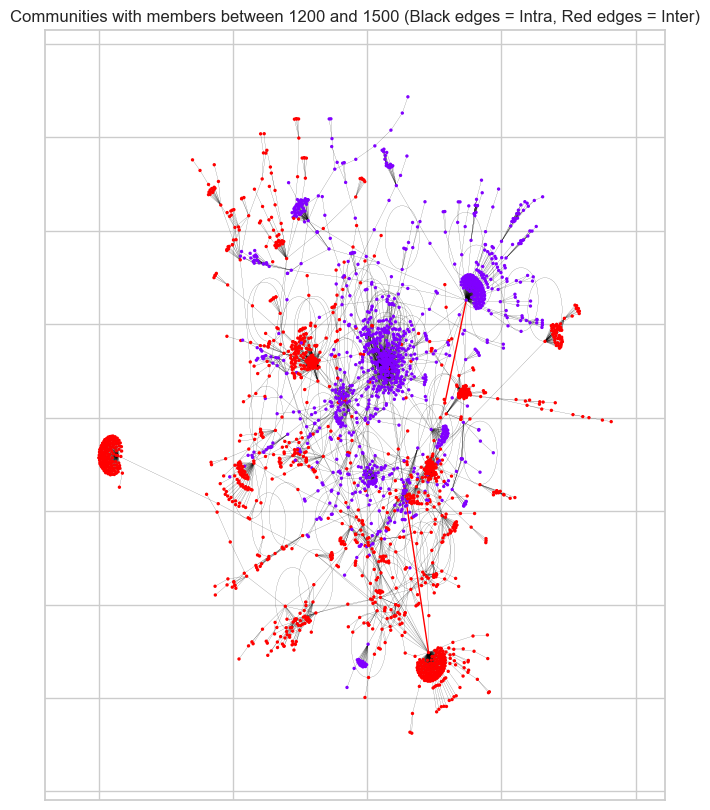

In [102]:
plot_communities_with_members(1200, 1500)

Number of communities with memebers between 2500 and 7000 is: 2


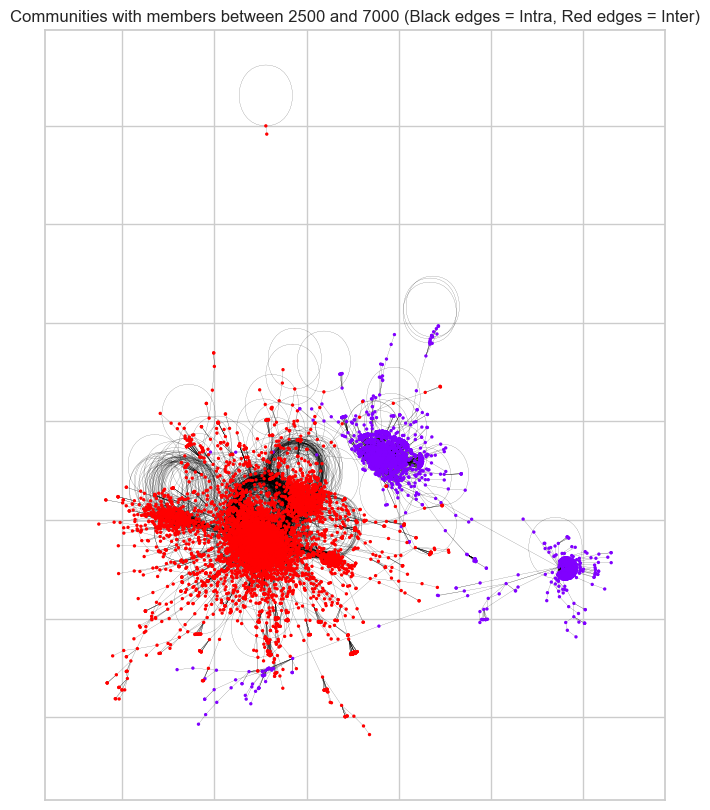

In [119]:
plot_communities_with_members(2500, 7000)